In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
import sys
MODEL_PATH = Path("Model")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [3]:
class ModelV1(nn.Module):
    def __init__(self):
        super(ModelV1, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=5
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropuot = nn.Dropout()
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=5
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=13456,
                out_features=20
            ),
            nn.Tanh(),
            nn.Linear(
                in_features=20,
                out_features=1
            )
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.dropuot(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x

In [4]:
class MRI(Dataset):
    def __init__(self, path, transform=None):
        self.images = []
        self.labels = []
        data_path = Path(path)
        image_path_list = list(data_path.glob("*/*.jpg"))
        for i in range(len(image_path_list)):

            if image_path_list[i].parent.stem == "no":
                self.labels.append(0)
            else:
                self.labels.append(1)
            img = cv2.imread(image_path_list[i])
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = torch.from_numpy(img).type(torch.float32) / 255
            
            if transform is not None:
                tImg = transform(img)
                tImg = tImg.permute(2, 1, 0)
                self.images.append(tImg)
                if image_path_list[i].parent.stem == "no":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
                    
            img = img.permute(2, 1, 0)
            self.images.append(img)
        self.labels = torch.tensor(self.labels).type(torch.float32)
         
    def __getitem__(self, idx):

        sample = {'image': self.images[idx], 'label': self.labels[idx]}
        
        return sample
    
    def __len__(self):
        return len(self.images)
    
    def normalize(self):
        self.images = self.images / 255.0

    def image_show(self, index):
        plt.imshow(self.images[index].reshape(self.images[index].shape[2], self.images[index].shape[1], self.images[index].shape[0]))
        title = "Yes" if self.labels[index] else "No"
        plt.title(f"Tumor Situation: {title}")
        plt.axis(False)



In [5]:

train_transform = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, 5)),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5)
])

In [6]:
mri_train = MRI("data/brain_tumor_dataset/train", transform=train_transform)
mri_test = MRI("data/brain_tumor_dataset/test")
model = ModelV1().to(device)

In [7]:
train_dataloader = DataLoader(mri_train, batch_size=18, shuffle=True)
test_dataloader = DataLoader(mri_test, batch_size=18, shuffle=False)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)
accuracies = []

In [8]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    losses = 0
    model.train()
    for _, data in enumerate(dataloader):
        optimizer.zero_grad()
        img, label = data["image"].to(device), data["label"].to(device).unsqueeze(1)
        y_pred = model(img)
        loss = loss_fn(y_pred, label)

        losses += loss.item()
        loss.backward()
        optimizer.step()
    losses /= len(dataloader)
    return losses

def test_step(model, dataloader, loss_fn, device):
    test_losses = 0
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(dataloader):
            image = data['image'].to(device)
            label = data['label'].to(device).unsqueeze(1)
            
            y_pred = model(image)
            loss = loss_fn(y_pred, label)

            test_losses += loss.item()
    test_losses /= len(dataloader)
    return test_losses

def train_loop(epochs, model, train_dataloader, test_dataloader, optimizer, loss_fn, device):
    epoch_train_loss = []
    epoch_test_loss = []
    for epoch in range(epochs):
        train_loss = train_step(
                        model = model,
                        dataloader = train_dataloader, 
                        loss_fn = loss_fn, 
                        optimizer = optimizer,
                        device = device
                    )
        test_loss = test_step(
                        model = model,
                        dataloader = test_dataloader,
                        loss_fn = loss_fn,
                        device = device
                    )
        if (epoch+1) % 10 == 0:
            print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, train_loss ,test_loss))
        epoch_train_loss.append(train_loss)
        epoch_test_loss.append(test_loss)
    return epoch_train_loss, epoch_test_loss

In [9]:
global_result = [[], []]

In [24]:

results = train_loop(
    epochs = 20, 
    model = model, 
    train_dataloader = train_dataloader, 
    test_dataloader = test_dataloader, 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-2),
    loss_fn =  nn.BCELoss(),
    device = device
)
train = results[0]
test = results[1]
for i in train:
    global_result[0].append(i)
for i in test:
    global_result[1].append(i)


Train Epoch: 10	Train Loss: 0.136938	Val Loss: 0.490021
Train Epoch: 20	Train Loss: 0.157732	Val Loss: 0.623832


In [25]:
def eval_model(model, validation_dataloader, device):
    outputs = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(validation_dataloader):
            image = data['image'].to(device)
            label = data['label'].to(device).unsqueeze(1)
            
            y_pred = model(image)
            predictions = (y_pred >= 0.5).float()

            outputs.append(predictions.cpu().numpy())
            y_true.append(label.cpu().detach().numpy())

    outputs = np.concatenate(outputs, axis = 0).squeeze()
    y_true = np.concatenate(y_true, axis = 0).squeeze()
    acc = accuracy_score(y_true, outputs)
    print(acc)
    return y_true, outputs
true_labels, predicted_labels = eval_model(model = model, validation_dataloader=test_dataloader, device = device)  

0.7083333333333334


In [26]:
def plot_losses(train_loss, test_loss):
    plt.figure(figsize=(16,9))
    plt.plot(train_loss, c='b', label='Train loss')
    plt.plot(test_loss, c='r', label = 'Validation loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)

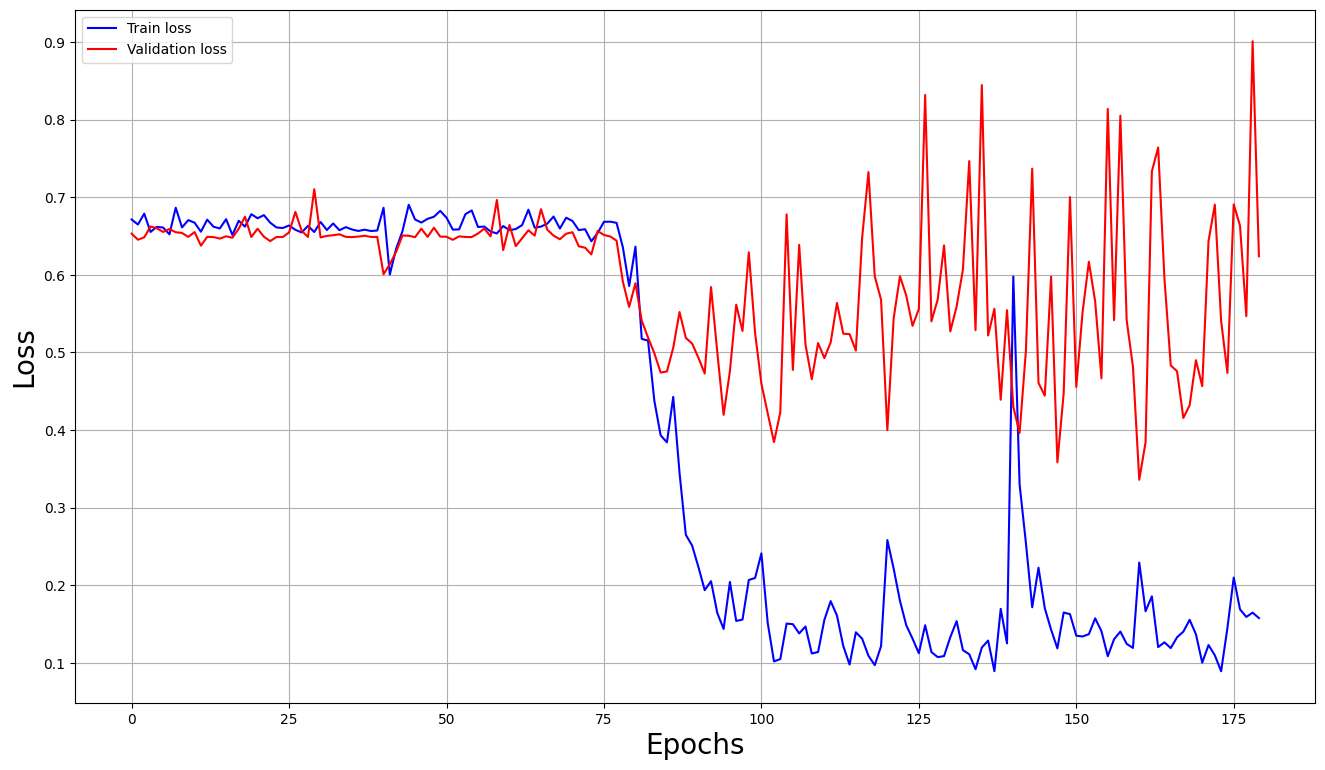

In [27]:
plot_losses(global_result[0], global_result[1])

In [28]:
import seaborn as sns
def plot_confusion_matrix(y_true, preds, label1, label2):
    plt.figure(figsize=(16,9))
    cm = confusion_matrix(y_true, preds)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', fontsize=20)
    ax.set_ylabel('True labels', fontsize=20) 
    ax.set_title('Confusion Matrix', fontsize=20)
    ax.xaxis.set_ticklabels([label1,label2], fontsize=20)
    ax.yaxis.set_ticklabels([label1,label2], fontsize=20)

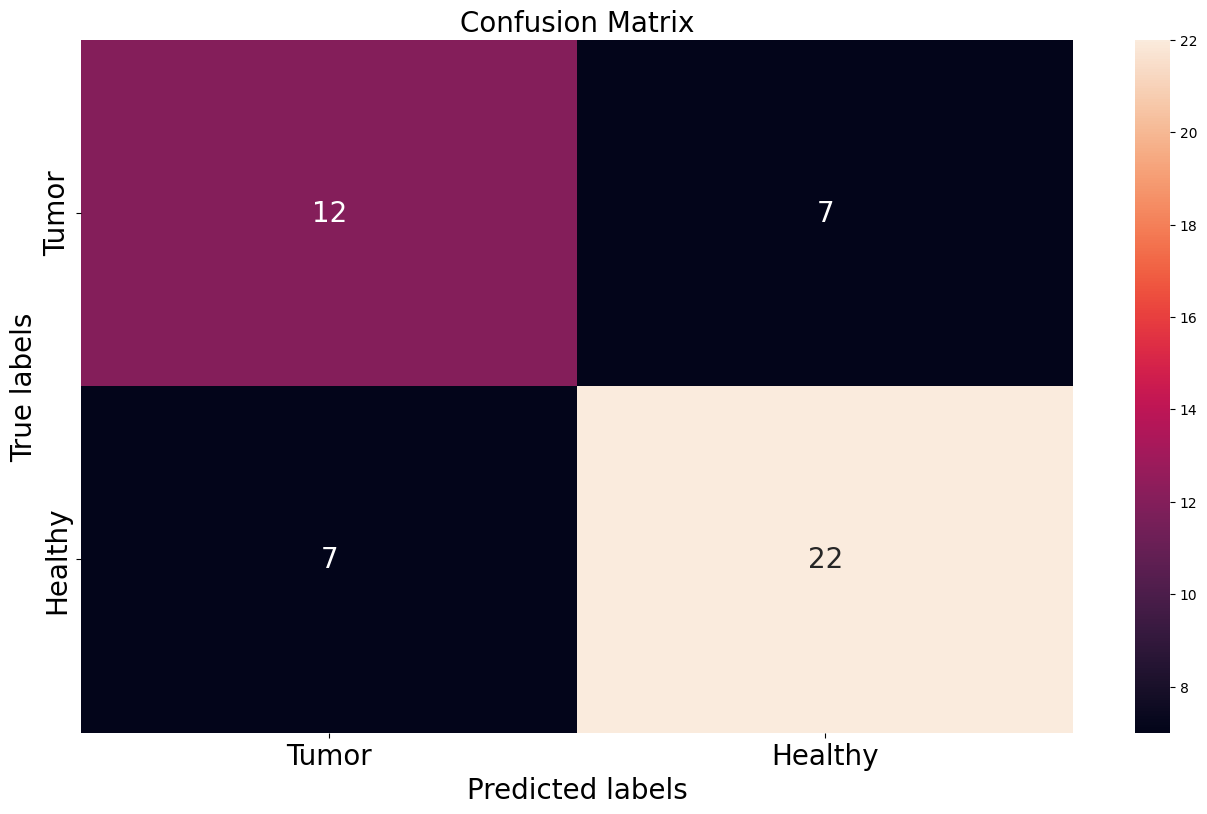

In [29]:
plot_confusion_matrix(true_labels, predicted_labels, "Tumor", "Healthy")

In [39]:
def model_saver(model, file_name):
    MODEL_SAVE_PATH = MODEL_PATH / file_name
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

def model_loader(model_class, file_name):
    MODEL_SAVE_PATH = MODEL_PATH / file_name
    try:
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        # Load the saved model for evaluation
        model = model_class
        model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    except:
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        model = model_class
    model.eval()
    return model
model_saver(model, "modelv0WithAugmentation")
model = model_loader(ModelV1().to(device), "modelv0WithAugmentation")

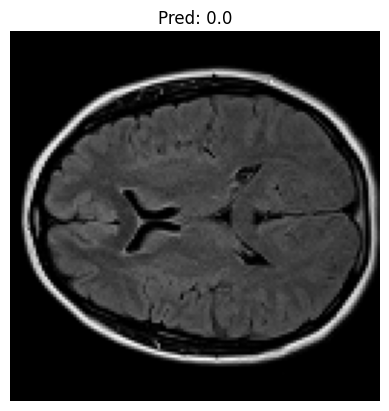

In [40]:
def custom_image_pred(data_path, model):
    custom_img = Path(data_path)
    custom_img = cv2.imread(custom_img)
    custom_img = cv2.resize(custom_img, (128, 128))
    b, g, r = cv2.split(custom_img)
    img = cv2.merge([r, g, b])
    img = torch.from_numpy(img).type(torch.float32) / 255
    img = img.permute(2, 1, 0).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        custom_pred = model(img.to(device))
        pred = (custom_pred >= 0.5).float()
    plt.imshow(img.squeeze().permute(1, 2, 0))
    title = f"Pred: {pred[0][0]}"
    plt.axis(False)
    plt.title(title)
custom_image_pred("data/no/no 99.jpg", model)